## ExtraTreesClassifier

ExtraTreesClassifier is an ensemble learning method fundamentally based on decision trees. ExtraTreesClassifier, like RandomForest, randomizes certain decisions and subsets of data to minimize over-learning from the data and overfitting.

**Decision Tree (High Variance)**

A single decision tree is usually overfits the data it is learning from because it learn from only one pathway of decisions. Predictions from a single decision tree usually don’t make accurate predictions on new data.

**Random Forest (Medium Variance)**

Random forest models reduce the risk of overfitting by introducing randomness by:

1.  Building multiple trees (n_estimators)
2. **Drawing observations with replacement (i.e., a bootstrapped sample)**
3.  **Splitting nodes on the best split among a random subset of the features selected at every node.**

**Extra Trees (Low Variance)**

Extra Trees is like Random Forest, in that it builds multiple trees and **splits nodes using random subsets of features**, but with two key differences ,it does not bootstrap observations (meaning it samples without replacement) and Nodes are split on random splits, not best splits. 
In summary, ExtraTrees:
1.  Builds multiple trees with bootstrap = False by default, which means it samples without replacement.
2.  Nodes are split based on random splits among a random subset of the features selected at every node
3.  When choosing variables at a split, samples are drawn from the entire training set instead of a bootstrap sample of  the training set.
4.  Unlike bagging and random forest that develop each decision tree from a bootstrap sample of the training dataset, the Extra Trees algorithm fits each decision tree on the whole training dataset.
5.  Predictions are made by averaging the prediction of the decision trees in the case of regression or using majority voting in the case of classification.
6.  Like random forest, the Extra Trees algorithm randomly sample the features at each split point of a decision tree. Unlike random forest, which uses a greedy algorithm to select an optimal split point, the Extra Trees algorithm selects a split point at random.
7.  There are three main hyperparameters to tune in the algorithm; they are the number of decision trees in the ensemble, the number of input features to randomly select and consider for each split point, and the minimum number of samples required in a node to create a new split point.
8.  

In Extra Trees, randomness doesn’t come from bootstrapping of data, but rather comes from the random splits of all observations. ExtraTrees is named for (Extremely Randomized Trees).

**Random Forest implementation in scikit-learn makes it possible to enable or disable the bootstrap resampling.**

**In practice, RFs are often more compact than ETs.** ETs are generally cheaper to train from a computational point of view but can grow much bigger. ETs can sometime generalize better than RFs but it's hard to guess when it's the case without trying both first (and tuning n_estimators, max_features and min_samples_split by cross-validated grid search).


ExtraTrees classifier always tests random splits over fraction of features (in contrast to RandomForest, which tests all possible splits over fraction of features)
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

**Lets make_classification() function to create a synthetic binary classification problem with 1,000 examples and 20 input features.**

In [1]:
import numpy as np
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split,GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## I downloaded both files and store at my Github profile.
df_nba = pd.read_csv("https://raw.githubusercontent.com/atulpatelDS/Data_Files/master/NBA_rookie/NBA_rookie.csv")

Dataset for practicing classification -use NBA rookie stats to predict if player will last 5 years in league

Classification Exercise: Predict 5-Year Career Longevity for NBA Rookies

y = 0 if career years played < 5

y = 1 if career years played >= 5

<img src="https://raw.githubusercontent.com/atulpatelDS/Machine_Learning/master/Images/NBA_Column_Description.png" width="340" height="240" align="left"/>

In [3]:
print(df_nba.shape)
print(type(df_nba))

(1340, 21)
<class 'pandas.core.frame.DataFrame'>


In [4]:
df_nba.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [5]:
## Check the intial data type, null value and unique counts
def initial_dataset_check(df):
    """
    A function to make initial check for the dataset including the name, data type, 
    number of null values and number of unique varialbes for each feature.
    """
    columns = df.columns    
    lst = []
    for feature in columns : 
        dtype = df[feature].dtypes
        num_null = df[feature].isnull().sum()
        num_unique = df[feature].nunique()
        lst.append([feature, dtype, num_null, num_unique])
    
    check_df = pd.DataFrame(lst)
    check_df.columns = ['feature','dtype','num_null','num_unique']
    check_df = check_df.sort_values(by='dtype', axis=0, ascending=True)
    
    return check_df

In [6]:
initial_dataset_check(df_nba)

,feature,dtype,num_null,num_unique
1,GP,int64,0,70
10,FTM,float64,0,59
18,BLK,float64,0,28
17,STL,float64,0,26
16,AST,float64,0,77
15,REB,float64,0,101
14,DREB,float64,0,74
13,OREB,float64,0,44
12,FT%,float64,0,383
11,FTA,float64,0,76


In [7]:
df_nba["3P%"].isnull().sum()

11

In [8]:
## Lets replace null value with mean
df_nba["3P%"] = df_nba["3P%"].fillna(value = df_nba["3P%"].mean())

In [9]:
df_nba["3P%"].isnull().sum()

0

In [10]:
X = df_nba.iloc[:,1:-1] ### Name need to remove which is distinct value
y = df_nba.TARGET_5Yrs

In [11]:
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(1340, 19)
(1340,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [12]:
## Now split the test train
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1072, 19)
(1072,)
(268, 19)
(268,)


In [14]:
## Define the model
extree_clf = ExtraTreesClassifier()
## Evaluate the model using CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
%time model_score = cross_val_score(extree_clf,X_train,y_train,scoring="accuracy",cv = cv , n_jobs=8,error_score="raise")
print('Model Accuracy: %.3f (%.3f)' % (np.mean(model_score), np.std(model_score)))

Wall time: 3.37 s
Model Accuracy: 0.676 (0.033)


We can also use the Extra Trees model as a final model and make predictions for classification.

In [15]:
extree_clf.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [16]:
## Now Evalauate the Model
y_pred = extree_clf.predict(X_test)
print("Model Accuracy : {}".format(metrics.accuracy_score(y_test,y_pred)))

Model Accuracy : 0.7052238805970149


#### Extra Trees Hyperparameters

An important hyperparameter for Extra Trees algorithm is the number of decision trees used in the ensemble.

Typically, the number of trees is increased until the model performance stabilizes. Intuition might suggest that more trees will lead to overfitting, although this is not the case. Bagging, Random Forest, and Extra Trees algorithms appear to be somewhat immune to overfitting the training dataset given the stochastic nature of the learning algorithm.

The number of trees can be set via the “n_estimators” argument and defaults to 100.

In [17]:
def modelfit(alg,X_train,y_train,X_test,y_test, X_cols, cv_folds=5):
    #Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    #y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    y_test_pred = alg.predict(X_test)
    #y_test_predprob = alg.predict_proba(X_test)[:,1]
    
    # Print the ROC_AUC on training dataset
    false_positive_rate_train, true_positive_rate_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred)
    roc_auc_score_train = metrics.roc_auc_score(y_train, y_train_pred)
    auc_train = metrics.auc(false_positive_rate_train, true_positive_rate_train)
    
    

    # Print the ROC_AUC on test dataset
    false_positive_rate_test, true_positive_rate_test, thresholds_test = metrics.roc_curve(y_test, y_test_pred)
    roc_auc_score_test = metrics.roc_auc_score(y_test, y_test_pred)
    auc_test = metrics.auc(false_positive_rate_test, true_positive_rate_test)
      
        
    #Print model report:
    print("\nBase Model Report with Default Parameters")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(y_train, y_train_pred))
    print("AUC (Train): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_train)
    print("Classification Report (Train): {}\n".format(metrics.classification_report(y_train,y_train_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_test, y_test_pred))
    print("AUC (Test): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_test)
    print("Classification Report (Test): {}\n".format(metrics.classification_report(y_test,y_test_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
            
    #Print Feature Importance:
    feat_imp = pd.Series(alg.feature_importances_, X_cols).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [18]:
def modelfit_GS(alg,X_train,y_train,X_test,y_test, X_cols):
    #Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    #y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    y_test_pred = alg.predict(X_test)
    #y_test_predprob = alg.predict_proba(X_test)[:,1]
    
    # Print the ROC_AUC on training dataset
    false_positive_rate_train, true_positive_rate_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred)
    roc_auc_score_train = metrics.roc_auc_score(y_train, y_train_pred)
    auc_train = metrics.auc(false_positive_rate_train, true_positive_rate_train)
    
    

    # Print the ROC_AUC on test dataset
    false_positive_rate_test, true_positive_rate_test, thresholds_test = metrics.roc_curve(y_test, y_test_pred)
    roc_auc_score_test = metrics.roc_auc_score(y_test, y_test_pred)
    auc_test = metrics.auc(false_positive_rate_test, true_positive_rate_test)
      
        
    #Print model report:
    print("\nBase Model Report with Default Parameters")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(y_train, y_train_pred))
    print("AUC (Train): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_train)
    print("Classification Report (Train): {}\n".format(metrics.classification_report(y_train,y_train_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_test, y_test_pred))
    print("AUC (Test): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_test)
    print("Classification Report (Test): {}\n".format(metrics.classification_report(y_test,y_test_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Best Score using GridSearch : {}\n".format(alg.best_score_))
    print("Best Parameter using GridSearch : {}\n".format(alg.best_params_))   
    
    ## Plot the Grapg with Mean test score 
    cv_results = pd.DataFrame(alg.cv_results_)
    plt.figure(figsize=(15,5))
    palette = sns.color_palette("Set1", n_colors=6, desat=.5)
    sns.lineplot(data=cv_results,x=cv_results.iloc[:,4],
                 y=cv_results.iloc[:,-3]
                 #,hue=cv_results["param_learning_rate"]
                 ,palette=palette
                 #,err_style="bars", ci=58,lw=1,err_kws={'capsize':0.5}
                 #,size=cv_results["param_learning_rate"]
                 #,sizes=(.25, 2.5)
                )

In [19]:
def plot_auc_gbm_parameter(param_value,param_name,X_train,y_train):
    from sklearn import metrics
    train_results = []
    test_results = []
    for param in param_value:
        param_gs = {param_name:param_value}
        model = GridSearchCV(estimator=ExtraTreesClassifier(random_state=10),param_grid=param_gs,n_jobs=8)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
        roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
        roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(param_value, train_results, color = 'green',label = "Train AUC") 
    line2, = plt.plot(param_value, test_results,color = 'red' ,label = "Test AUC") 
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("AUC score")
    plt.xlabel(param_name)
    plt.show()

In [20]:
X_cols = [x for x in X_train.columns]
X_cols

['GP',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG%',
 '3P Made',
 '3PA',
 '3P%',
 'FTM',
 'FTA',
 'FT%',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV']


Base Model Report with Default Parameters
Accuracy (Train) : 0.9841
AUC (Train): 0.986696
ROC_AUC_Score (Train): 0.986696
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       410
         1.0       1.00      0.98      0.99       662

    accuracy                           0.98      1072
   macro avg       0.98      0.99      0.98      1072
weighted avg       0.98      0.98      0.98      1072


Accuracy (Test) : 0.7052
AUC (Test): 0.986696
ROC_AUC_Score (Train): 0.659584
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.63      0.48      0.55        99
         1.0       0.73      0.83      0.78       169

    accuracy                           0.71       268
   macro avg       0.68      0.66      0.66       268
weighted avg       0.70      0.71      0.70       268




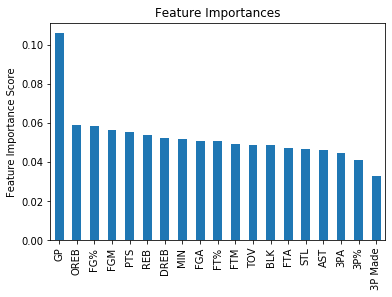

In [21]:
modelfit(extree_clf,X_train,y_train,X_test,y_test, X_cols)

In [22]:
## Tune the no. of Tree
predictors = X_cols
param_value1 = range(10,300,20)
param_name1 = "n_estimators"
param_test1 = {"n_estimators":range(10,300,20)}
gs_extratree_clf1 = GridSearchCV(estimator = ExtraTreesClassifier(random_state=10),param_grid = param_test1,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [23]:
%time gs_extratree_clf1.fit(X_train,y_train)

Wall time: 5.45 s


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=10,
                                            verbose=0, warm_start=False),
             iid='deprecated'


Base Model Report with Default Parameters
Accuracy (Train) : 0.9841
AUC (Train): 0.986696
ROC_AUC_Score (Train): 0.986696
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       410
         1.0       1.00      0.98      0.99       662

    accuracy                           0.98      1072
   macro avg       0.98      0.99      0.98      1072
weighted avg       0.98      0.98      0.98      1072


Accuracy (Test) : 0.7015
AUC (Test): 0.986696
ROC_AUC_Score (Train): 0.660809
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.62      0.51      0.56        99
         1.0       0.74      0.82      0.78       169

    accuracy                           0.70       268
   macro avg       0.68      0.66      0.67       268
weighted avg       0.69      0.70      0.69       268


Best Score using GridSearch : 0.7152078505576579

Best Parameter using GridSearch 

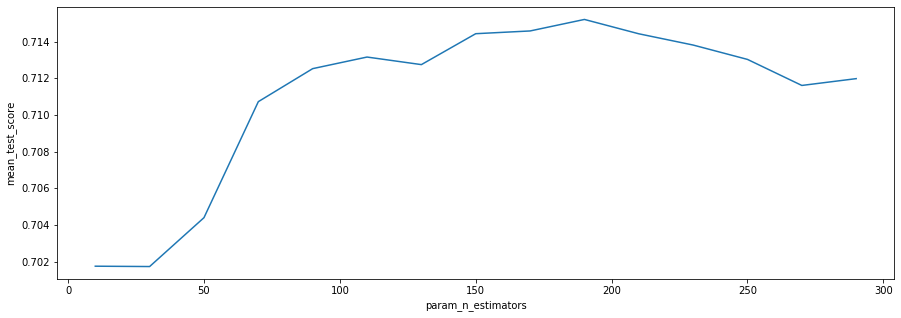

In [24]:
modelfit_GS(gs_extratree_clf1,X_train,y_train,X_test,y_test, X_cols)

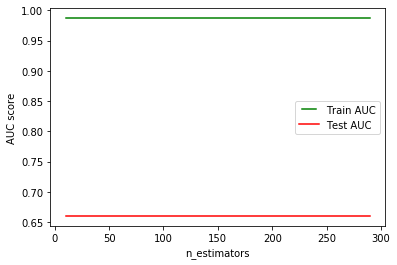

Wall time: 1min 33s


In [25]:
%time plot_auc_gbm_parameter(param_value1,param_name1,X_train,y_train)

In [26]:
## Tune the "min_samples_split":range(2, 15)
param_value2 = range(2,20,2)
param_name2 = "min_samples_split"
param_test2 = {"min_samples_split":range(2,20,2)}
gs_extratree_clf2 = GridSearchCV(estimator = ExtraTreesClassifier(random_state=10,n_estimators=190),param_grid = param_test2,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [27]:
%time gs_extratree_clf2.fit(X_train,y_train)

Wall time: 4.24 s


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=190, n_jobs=None,
                                            oob_score=False, random_state=10,
                                            verbose=0, warm_start=False),
             iid='deprecated'


Base Model Report with Default Parameters
Accuracy (Train) : 0.9049
AUC (Train): 0.883037
ROC_AUC_Score (Train): 0.883037
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.95      0.79      0.86       410
         1.0       0.88      0.98      0.93       662

    accuracy                           0.90      1072
   macro avg       0.92      0.88      0.90      1072
weighted avg       0.91      0.90      0.90      1072


Accuracy (Test) : 0.7201
AUC (Test): 0.883037
ROC_AUC_Score (Train): 0.677694
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.65      0.52      0.58        99
         1.0       0.75      0.84      0.79       169

    accuracy                           0.72       268
   macro avg       0.70      0.68      0.68       268
weighted avg       0.71      0.72      0.71       268


Best Score using GridSearch : 0.7319194605138122

Best Parameter using GridSearch 

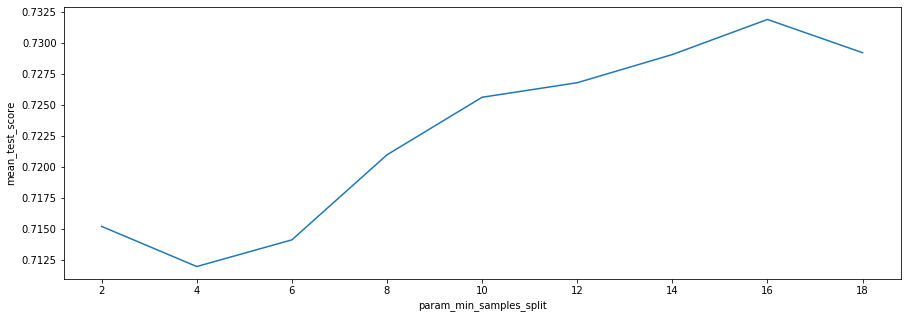

In [28]:
modelfit_GS(gs_extratree_clf2,X_train,y_train,X_test,y_test, X_cols)

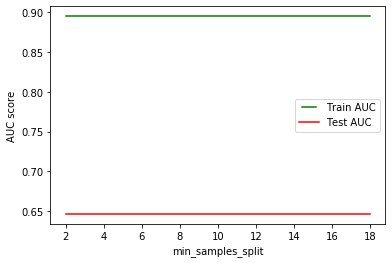

Wall time: 21 s


In [29]:
%time plot_auc_gbm_parameter(param_value2,param_name2,X_train,y_train)

In [30]:
## Tune "max_features":range(1,21)}
param_value3 = range(1,20,1)
param_name3 = "max_features"
param_test3 = {"max_features":range(1,20,1)}
gs_extratree_clf3 = GridSearchCV(estimator = ExtraTreesClassifier(random_state=10,n_estimators=190,min_samples_split= 16)
                                 ,param_grid = param_test3,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [31]:
%time gs_extratree_clf3.fit(X_train,y_train)

Wall time: 10.6 s


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=16,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=190, n_jobs=None,
                                            oob_score=False, random_state=10,
                                            verbose=0, warm_start=False),
             iid='deprecated


Base Model Report with Default Parameters
Accuracy (Train) : 0.9049
AUC (Train): 0.883037
ROC_AUC_Score (Train): 0.883037
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.95      0.79      0.86       410
         1.0       0.88      0.98      0.93       662

    accuracy                           0.90      1072
   macro avg       0.92      0.88      0.90      1072
weighted avg       0.91      0.90      0.90      1072


Accuracy (Test) : 0.7201
AUC (Test): 0.883037
ROC_AUC_Score (Train): 0.677694
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.65      0.52      0.58        99
         1.0       0.75      0.84      0.79       169

    accuracy                           0.72       268
   macro avg       0.70      0.68      0.68       268
weighted avg       0.71      0.72      0.71       268


Best Score using GridSearch : 0.7319194605138122

Best Parameter using GridSearch 

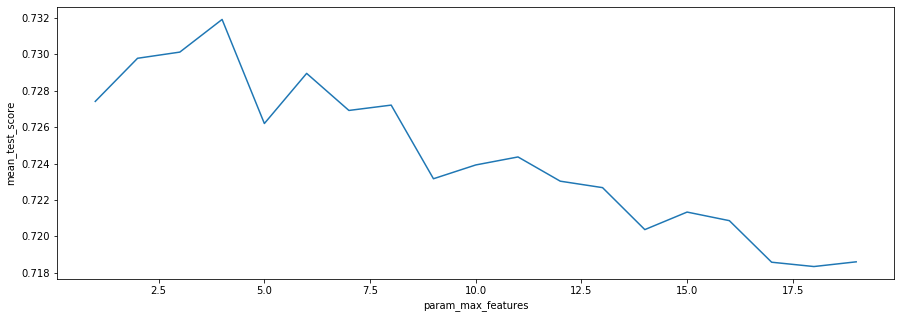

In [32]:
modelfit_GS(gs_extratree_clf3,X_train,y_train,X_test,y_test, X_cols)

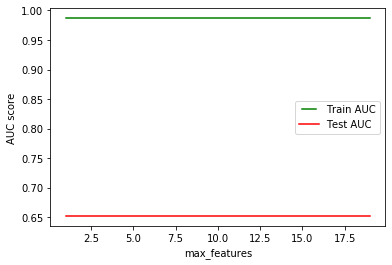

Wall time: 2min 6s


In [33]:
%time plot_auc_gbm_parameter(param_value3,param_name3,X_train,y_train)

In [34]:
## Lets create the final Model using best parameters
extree_clf_final = ExtraTreesClassifier(random_state=10,n_estimators=190,min_samples_split= 16,max_features=4,n_jobs=8)
extree_clf_final.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=4,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=16,
                     min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=8,
                     oob_score=False, random_state=10, verbose=0,
                     warm_start=False)


Base Model Report with Default Parameters
Accuracy (Train) : 0.9049
AUC (Train): 0.883037
ROC_AUC_Score (Train): 0.883037
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.95      0.79      0.86       410
         1.0       0.88      0.98      0.93       662

    accuracy                           0.90      1072
   macro avg       0.92      0.88      0.90      1072
weighted avg       0.91      0.90      0.90      1072


Accuracy (Test) : 0.7201
AUC (Test): 0.883037
ROC_AUC_Score (Train): 0.677694
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.65      0.52      0.58        99
         1.0       0.75      0.84      0.79       169

    accuracy                           0.72       268
   macro avg       0.70      0.68      0.68       268
weighted avg       0.71      0.72      0.71       268




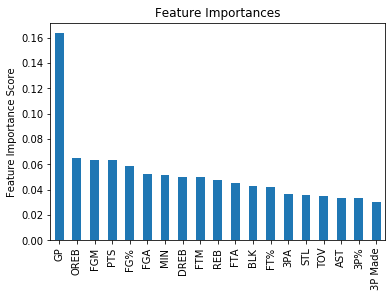

In [35]:
## Evaluate the final Model
modelfit(extree_clf_final,X_train,y_train,X_test,y_test, X_cols)